In [1]:
from dotenv import load_dotenv
!pip install --quiet boto3
!pip install --quiet python-dotenv
import boto3
import os
import pandas as pd


In [2]:
load_dotenv()

s3 = boto3.client(
    "s3",
    # aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    # aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    # endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"),
)

In [3]:
BUCKET_NAME = "marathon"

In [4]:
# Sending files to Ocean Storage
s3.upload_file(Filename='halfmarathon_wroclaw_2024__final.csv', 
               Bucket = BUCKET_NAME, 
               Key="marathon/year=2024/halfmarathon_wroclaw_2024__final.csv")

In [5]:
os.makedirs("download", exist_ok=True)

s3.download_file(BUCKET_NAME, "marathon/year=2024/halfmarathon_wroclaw_2024__final.csv", "download/halfmarathon_wroclaw_2024__final.csv")

df=pd.read_csv('halfmarathon_wroclaw_2024__final.csv', sep=';')

df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,596,NIKODEM,DWORCZAK,KOŚCIAN,POL,NaN,M,1.0,M20,...,2.920000,00:45:07,2.0,3.083333,01:00:33,1.0,3.086667,0.007267,01:04:03,3.036265
1,2.0,616,MATEUSZ,KACZOR,RADOM,POL,RLTL OPTIMA RADOM,M,2.0,M20,...,2.920000,00:45:07,3.0,3.083333,01:00:38,2.0,3.103333,0.008267,01:04:24,3.052856
2,3.0,154,PATRYK,KOZŁOWSKI,RADOM,POL,RLTL-ZTE-RADOM,M,3.0,M20,...,2.920000,00:45:07,1.0,3.083333,01:00:59,3.0,3.173333,0.012467,01:04:40,3.065497
3,4.0,591,DARIUSZ,BORATYŃSKI,WROCŁAW,POL,WOSIEK TEAM AZS AWF WROCŁAW,M,4.0,M20,...,3.110000,00:47:48,4.0,3.293333,01:05:40,4.0,3.573333,0.028667,01:09:44,3.305681
4,5.0,521,SZYMON,DOROŻYŃSKI,LUBON,POL,SZYMI TEAM AZS POLITECHNIKA OPOLSKA,M,5.0,M30,...,3.153333,00:48:09,5.0,3.453333,01:06:05,5.0,3.586667,0.039800,01:10:05,3.322272


In [6]:
# Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [7]:
#Changing time columns with function
df['Czas'] = df['Czas'].apply(convert_time_to_seconds)
df['5 km Czas'] = df['5 km Czas'].apply(convert_time_to_seconds)
df['10 km Czas'] = df['10 km Czas'].apply(convert_time_to_seconds)
df['15 km Czas'] = df['15 km Czas'].apply(convert_time_to_seconds)
df['20 km Czas'] = df['20 km Czas'].apply(convert_time_to_seconds)

In [8]:
#Zostawiam kolumny które według mnie mają znaczenie przy estymowaniu czasu i wyszły najlepiej po kilku eksperymantach z modelami
df1 = df[['Płeć', 'Rocznik', '5 km Czas',
        '15 km Czas', 'Czas']].copy()

In [9]:
#Sprawdzam odsetek brakujacych danych w dataset- zwłaszcza w kolumnie docelowej "Czas"
df1.isna().sum() / len(df1) * 100

Płeć           0.069194
Rocznik        2.183440
5 km Czas     20.904129
15 km Czas    20.911817
Czas          20.811871
dtype: float64

In [10]:
#Usuwam wiersze w których w kolumnie Czas występuje NaN
df1= df1.dropna(subset=["Czas"])

In [11]:
#Sprawdzam ponownie ile brakuje danych w pozostałych kolumnach po usunięciu braków w kolumnie docelowej
df1.isna().sum() / len(df1) * 100

Płeć          0.000000
Rocznik       2.757282
5 km Czas     0.116505
15 km Czas    0.126214
Czas          0.000000
dtype: float64

In [12]:
#Dla zmiennych NaN w kolumnach 5 km Czas, 15 km Czas  wprowadzam wartości średnie dla poszczególnych kolumn
df1['5 km Czas'].fillna(df1['5 km Czas'].mean(), inplace=True)
df1['15 km Czas'].fillna(df1['15 km Czas'].mean(), inplace=True)


In [13]:
df1.isna().sum() / len(df1) * 100

Płeć          0.000000
Rocznik       2.757282
5 km Czas     0.000000
15 km Czas    0.000000
Czas          0.000000
dtype: float64

In [14]:
#Sprawdzam czy w kolumnie Rocznik występują wartości poniżej 1924- zakładam, że 100 latkowie i starsi ludzie nie biegli
df1[df1["Rocznik"] < 1924]

,Płeć,Rocznik,5 km Czas,15 km Czas,Czas
2279,M,0.0,1566.000000,4491.000000,6509.0
5592,M,0.0,1641.000000,5140.000000,7462.0
6011,M,0.0,1664.000000,5250.000000,7593.0
7138,M,0.0,1698.150855,5163.495577,7962.0
7716,K,0.0,1921.000000,5757.000000,8201.0
8869,M,0.0,1988.000000,6087.000000,8811.0
9360,M,0.0,2002.000000,6193.000000,9165.0
9703,M,0.0,1948.000000,6464.000000,9562.0
9829,M,0.0,1698.150855,5163.495577,9732.0
10036,M,0.0,2083.000000,6889.000000,10168.0


In [15]:
#Dla kolumny rocznik obliczam wartość średnią i nie biorę pod uwagę wartości 0.0 i dla wartości 0.0 oraz NaN wstawiam wartości średnie
mean_rocznik = df1[df1['Rocznik'] != 0.0]['Rocznik'].mean()
df1.loc[df1['Rocznik'] == 0.0, 'Rocznik'] = mean_rocznik
df1.loc[df1['Rocznik'].isnull(), 'Rocznik'] = mean_rocznik

In [16]:
#Usuwam wartości odstające aby nie wpływały one zbyt na model
columns=["Rocznik", "5 km Czas", "15 km Czas", "Czas"]
for column in columns:
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df1_without_outliers = df1[~((df1[column] < lower_bound) | (df1[column] > upper_bound))]

In [17]:
from pycaret.regression import setup, compare_models, finalize_model, plot_model, save_model, load_model, predict_model

In [18]:
#Tworzę eksperyment, nie wyrzucam żadnych kolumn, bo zrobiłem to już przygotowując DataSet do eksperymentu
exp = setup(
    data=df1_without_outliers,
    target="Czas",
    session_id=123,
)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(10175, 5)"
4,Transformed data shape,"(10175, 5)"
5,Transformed train set shape,"(7122, 5)"
6,Transformed test set shape,"(3053, 5)"
7,Numeric features,3
8,Categorical features,1
9,Preprocess,True


In [19]:
#Poszukuje najlepszego modelu regresji dla powyższych danych
best_model = exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,99.0218,22539.9021,149.2476,0.9830,0.0193,0.0130,0.1190
gbr,Gradient Boosting Regressor,103.5594,24010.5015,153.9475,0.9819,0.0200,0.0137,0.2450
rf,Random Forest Regressor,102.3675,24057.0217,154.4166,0.9819,0.0199,0.0134,0.8600
lasso,Lasso Regression,97.6991,24038.9434,153.2905,0.9818,0.0201,0.0128,0.0440
ridge,Ridge Regression,97.7881,24033.8693,153.2823,0.9818,0.0201,0.0128,0.0330
lar,Least Angle Regression,97.7891,24033.8957,153.2825,0.9818,0.0201,0.0128,0.0350
llar,Lasso Least Angle Regression,97.6989,24038.9509,153.2905,0.9818,0.0201,0.0128,0.0360
br,Bayesian Ridge,97.7557,24035.0745,153.2835,0.9818,0.0201,0.0128,0.0370
lr,Linear Regression,97.7891,24033.8957,153.2825,0.9818,0.0201,0.0128,0.7070
en,Elastic Net,98.0887,24248.9168,153.9384,0.9817,0.0201,0.0128,0.0390


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

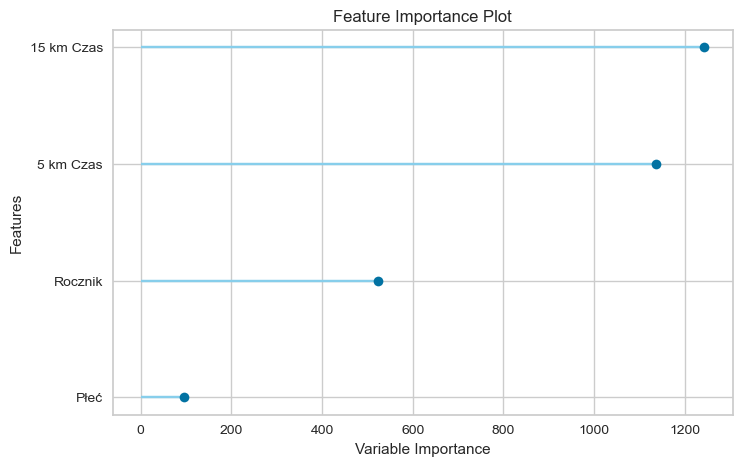

In [20]:
#Sprawdzam które zmienne i w jaki sposób wpływają na wynik
plot_model(best_model, plot='feature')

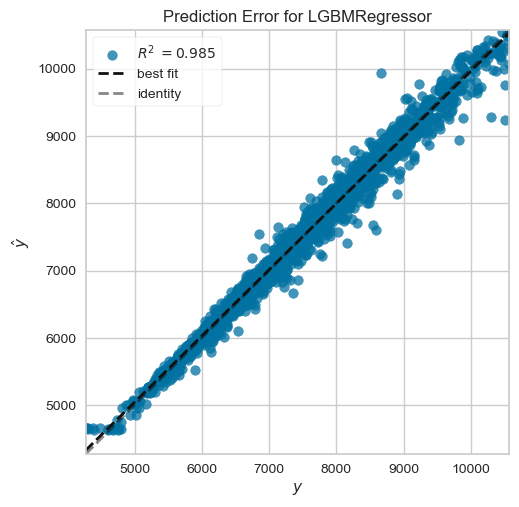

In [21]:
#Model dość dobrze przewiduje i przewiduje wynik bardzo zbliżony do wartości rzeczywistych
plot_model(best_model, plot='error')

In [22]:
#Finalizuję model
final_model = finalize_model(best_model)

In [23]:
#Zapisuję model lokalnie
save_model(final_model, 'regression_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Rocznik', '5 km Czas',
                                              '15 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mappin

In [25]:
#Upload modelu do Ocean Space
s3.upload_file(
    Filename='regression_pipeline.pkl',
    Bucket=BUCKET_NAME,
    Key='marathon/year=2024/regression_pipeline.pkl'
)